In [1]:
from typing import (
    Tuple,
    List,
    Dict,
    Any,
    Sequence,
    Union,
    Optional,
)

import sys
import time
import json
import re
from pathlib import Path
from enum import Enum
import shutil

import pandas as pd
import polars as pl
import polars.selectors as cs

# 상대 경로 사용
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'

# 로컬 모듈
# 맨 앞에 추가
if str(PROJECT_ROOT) in sys.path:
    sys.path.remove(str(PROJECT_ROOT))
sys.path.insert(0, str(PROJECT_ROOT))
from src.preprocess.preprocess import overview_col, analyze_null_values, eda_proportion

# 이제 import
from src.loading import DataLoader
from src.utils import increment_path

output_file = DATA_DIR / 'temp' / 'maude_clustered.parquet'
loader = DataLoader(
    # output_file= DATA_DIR / 'silver' / 'maude50.parquet',
    output_file= output_file,
)

adapter = 'polars'
polars_kwargs = {
    'use_statistics': True,
    'parallel': 'auto',
    'low_memory': False,
    'rechunk': False,
    'cache': True,
}
maude_lf = loader.load(adapter=adapter, **polars_kwargs)
maude_lf


📖 /home/dataiku/eric/Sparta/Project3/data/temp/maude_clustered.parquet 로딩 중... (adapter=polars)


In [5]:
from cuml import UMAP
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

# 1. GPU 메모리로 직접 전송
embedding_df: pl.DataFrame = maude_lf.select(pl.col('embeddings')).collect()
cluster_df: pl.DataFrame = maude_lf.select(pl.col('cluster')).collect()

[2025-12-24 17:29:12.117] [CUML] [debug] Computing KNN Graph
[2025-12-24 17:30:02.479] [CUML] [debug] Computing fuzzy simplicial set


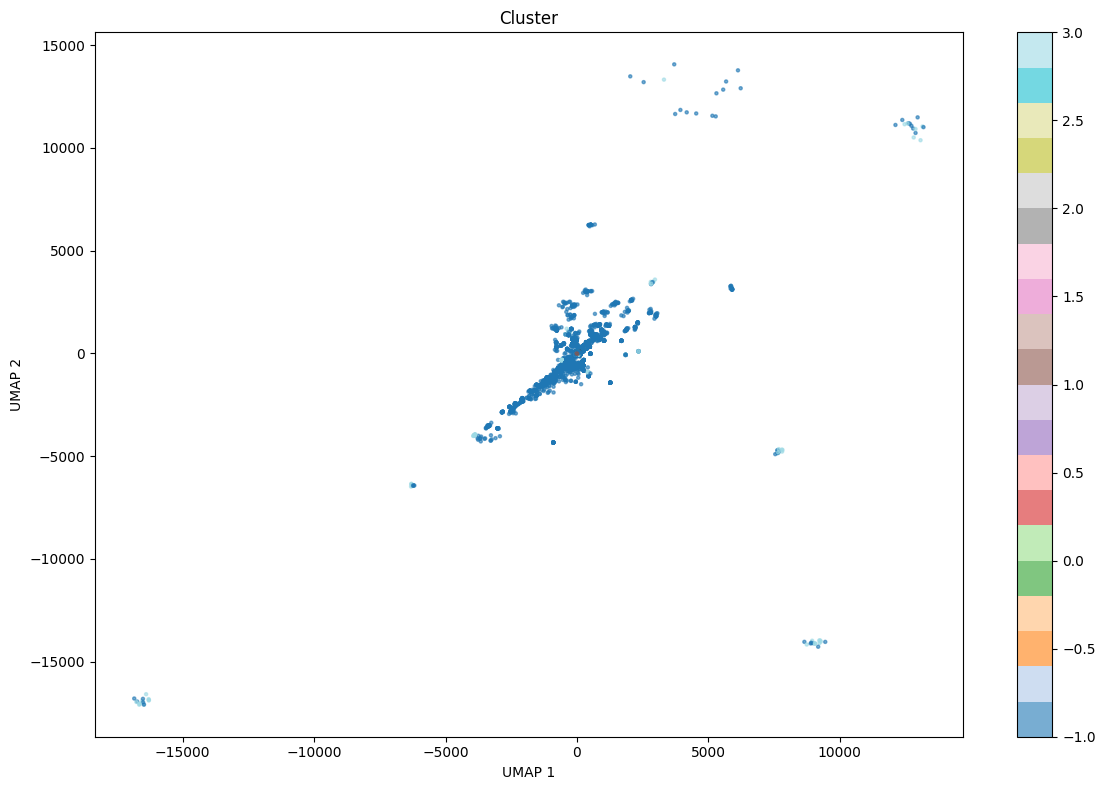

In [8]:
embeddings_array = np.vstack(embedding_df['embeddings'].to_list())
cluster = cluster_df['cluster'].to_numpy().flatten()

# 2. CuPy 배열로 변환 (GPU 메모리 활용)
embeddings_gpu = cp.asarray(embeddings_array, dtype=cp.float32)

# 3. UMAP 파라미터 최적화
umap_2d = UMAP(n_components=2, random_state=42)

# 4. GPU에서 변환
embedding_2d_gpu = umap_2d.fit_transform(embeddings_gpu)

# 5. 시각화를 위해
embedding_2d = cp.asnumpy(embedding_2d_gpu)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=cluster, 
    cmap='tab20', 
    alpha=0.6,
    s=5
)
plt.colorbar(scatter)
plt.title('Cluster')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.tight_layout()
plt.show()

# 메모리 정리
del embeddings_gpu, embedding_2d_gpu